Feature Engineering (FE)
===
Magic, secret behind the data, would help to classify the true.

1. [Classify which ones are true or fake data](#Magic-1,-divide-real-and-fake-test-samples)
- [Calculate Counts for each Unique Value](#Magic-frequency-counts)
- [Concatenate outputs]()

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook

import seaborn as sns
%matplotlib inline

In [2]:
import random,gc
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_validate
import os,datetime

import warnings,random
warnings.filterwarnings('ignore')

/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
#Reference  the bottom

W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red
G  = '\033[32m' # green
O  = '\033[1;33m' # orange
B  = '\033[34m' # blue
P  = '\033[35m' # purple

T =  '\033[1;33;47m' #Title

In [4]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

features=train_df.columns[2:]

In [5]:
import gc 
gc.collect()

786

1st Sol
---
1. Feature Engineering, Technical part:

The "magic" is about count of values, especially the fact that some are unique. We created 200 (one per raw feature) categorical features, let's call them "has one feat", with 5 categories that corresponds (for train data) to:
- This value appears at least another time in data with target==1 and no 0;
- This value appears at least another time in data with target==0 and no 1;
- This value appears at least two more time in data with target==0 & 1;
- This value is unique in data;
- This value is unique in data + test (only including real test samples);

The other 200 (one per raw feature) features are numerical, let's call them "not unique feat", and correspond to the raw feature replacing values that are unique in data + test with the mean of the feature.




2nd Sol
---
1. <del>remove fake from test</del>
- concat train and test, and then invert some of features
- standard scaling
- count encoding
- count round encoding
- unpivot all vars(so we have 200k x 200 = 4m train samples)
- train and predict
- convert prediction(200k x 200) into odds. We used (9 * p / 1 - p)


Magics
===
Basic Magic
---
This competition converts all the features data into certain `unknown` distributed data. As common sense, correlation between new feature and `target` might be positive to negative; to prevant overfiiting in train stage, for instance lightgbm model, we would rather change the data in each feature in positive `correlated` with target feature.  


Magic 1, divide real and fake test samples
---

```
features   f0, f1, f2, ...
  data
   d0       
   d1      ⬇︎
   d2
   :
``` 
1. Only data, owning unique value, could be real there, otherwise were duplicated for test with large probability, by ```np.unique()```; and save it to ```unique_count = [row × column]```
- U = `np.sum(unique_count, axis=1)` gives array of uniques for each data
```
for instance, U = [ 0, 1, 0, 1       [ 2
                    0, 0, 0, 0    ➠     0
                    0, 1, 1, 1           3 
                    0, 0, 0, 0           0
                    ...]               ...]
```
- `np.argwhere(U > 0)[:, 0]` gives all the indecies of data, owing at least one uniques value.
```
   [ 2,
     0,     ➠ [0,2,...]
     3,
     0,
     ...]    
```


In [8]:
def corrlated_same(train,test,features,target):
    rev=[]
    for var in tqdm_notebook(features):
        if np.corrcoef( train[target], train[var] )[1][0] < 0:
           train[var] = train[var] * -1
           test_df[var]  = test_df[var]  * -1
           rev=np.append(rev,var) 
    return train,test,rev    

In [9]:
train_df,test_df,rev_var=corrlated_same(train_df,test_df,features,'target')

In [10]:
rev_var

array(['var_7', 'var_9', 'var_10', 'var_12', 'var_13', 'var_14', 'var_20',
       'var_21', 'var_23', 'var_27', 'var_28', 'var_31', 'var_33',
       'var_34', 'var_36', 'var_39', 'var_41', 'var_42', 'var_43',
       'var_44', 'var_45', 'var_50', 'var_54', 'var_56', 'var_57',
       'var_58', 'var_59', 'var_63', 'var_64', 'var_68', 'var_72',
       'var_73', 'var_75', 'var_76', 'var_77', 'var_80', 'var_81',
       'var_83', 'var_85', 'var_86', 'var_87', 'var_88', 'var_92',
       'var_93', 'var_98', 'var_101', 'var_102', 'var_103', 'var_104',
       'var_107', 'var_108', 'var_109', 'var_113', 'var_114', 'var_115',
       'var_116', 'var_120', 'var_121', 'var_122', 'var_123', 'var_127',
       'var_129', 'var_131', 'var_132', 'var_136', 'var_139', 'var_141',
       'var_142', 'var_143', 'var_146', 'var_148', 'var_149', 'var_150',
       'var_152', 'var_153', 'var_154', 'var_156', 'var_158', 'var_160',
       'var_165', 'var_166', 'var_169', 'var_172', 'var_174', 'var_177',
       'var_17

In [11]:
def unique_val_found(data_val):
    """
    input numpy array of data: data_val
    output: real_ind, fake_ind 
    """
    unique_samples = []
    unique_count = np.zeros_like(data_val)
    for feature in tqdm_notebook(range(data_val.shape[1])):
        # Filter out all the pair of (index,count)
        _, index_, count_ = np.unique(data_val[:, feature], return_counts=True, return_index=True)
        unique_count[index_[count_ == 1], feature] += 1

    # Samples which have unique values are real, or are fake
    real_ind = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
    fake_ind = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]
    r_n=len(real_ind)
    f_n=len(fake_ind)
    r_ratio=r_n/data_val.shape[0]
    print("no. of real samples: %s\nno. of fake samples: %s\nratio of real samples: %s" %(r_n,f_n,r_ratio))
    return real_ind,fake_ind
    

In [12]:
trn_=train_df.drop(['ID_code','target'], axis=1).values

trn_real_ind,trn_fake_ind=unique_val_found(trn_)


no. of real samples: 200000
no. of fake samples: 0
ratio of real samples: 1.0


In [13]:
te_=test_df.drop(['ID_code'], axis=1).values

te_real_ind,te_fake_ind=unique_val_found(te_)


no. of real samples: 100000
no. of fake samples: 100000
ratio of real samples: 0.5


Magic frequency counts
---
After filtering out true data in test set as above, delete the fake ones; and 

In [14]:
features = train_df.columns[2:]

X_train=train_df[features].copy()
y_train=train_df.target.values
X_test = test_df[features].copy()
X_real_test = X_test.iloc[te_real_ind]

In [15]:
X_train.shape, y_train.shape, X_test.shape, X_real_test.shape

((200000, 200), (200000,), (200000, 200), (100000, 200))

1. `df.value_counts()` gives the value (tmp) with frequency as follows:
```
  feature     frequency
     a           n1
     b           n2
     ...
``` 
2. df.map(tmp) maps value to its frequency; here clip by 6, the biggest.

In [16]:
def freq_count(train,test,real_test,cut=6):
    """
    input: train,test,real_test, cuts (opt)
    output: train,test (with new freq_count features), array of new features
    """
    count_cols = []
    features=train.columns
    for c in tqdm_notebook(features):
        count_col = c+'_count'
        tmp = pd.concat((train[c], real_test[c])).value_counts()
        # mean of target is small 
        train[count_col] = train[c].map(tmp).clip(0, cut)
        test[count_col] = test[c].map(tmp).clip(0, cut).fillna(1)
        count_cols.append(count_col)
    print("%s features before, %s features after..." %(len(features),len(train.columns)))   
    return train,test,count_cols  

In [17]:
XX_train,XX_test,cols_new=freq_count(X_train,X_test,X_real_test)


200 features before, 400 features after...


In [18]:
len(XX_train.columns)

400

Single model Training
---

In [22]:
param = {
    'bagging_freq': 5,          
    'bagging_fraction': 0.23+0.77,
    'bootstrap' :  True,
    'bagging_with_replacement' : True,
    'boost_from_average':'false',   
    'boost': 'gbdt',#'dart',
    # The var_count have to be considered together, turn the fraction BE 1!
    'feature_fraction': 0.04+0.06+0.9,   
    'learning_rate': 0.006,     
    'max_depth': -1,
    'num_leaves': 64,
    'metric':'auc',#'binary_logloss',
    'lambda_l1':0.01, 
    'lambda_l2':0.01*100,
    'min_data_in_leaf': 80,     
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13-10,           
    'num_threads': 8,
    'tree_learner': 'serial',
    #'max_bin': 40,
    'objective': 'binary', 
    'is_unbalance': 'true',
    'verbosity': 1
}


In [23]:
# with Magics
num_round = 1000000
features_m=X_train.columns.values
target=train_df['target']
train, test = train_test_split(X_train, test_size=0.2,random_state=random.randint(1,1e5))

trn_data=lgb.Dataset(train[features_m],label=target.iloc[train.index])
val_data=lgb.Dataset(test[features_m],label=target.iloc[test.index])

clf=lgb.train(param, trn_data,num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, 
              early_stopping_rounds = 500)

Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.7966	valid_1's auc: 0.788033
[2000]	training's auc: 0.833723	valid_1's auc: 0.823044
[3000]	training's auc: 0.853944	valid_1's auc: 0.84179
[4000]	training's auc: 0.86697	valid_1's auc: 0.853711
[5000]	training's auc: 0.876354	valid_1's auc: 0.862308
[6000]	training's auc: 0.883313	valid_1's auc: 0.868575
[7000]	training's auc: 0.889101	valid_1's auc: 0.873841
[8000]	training's auc: 0.893801	valid_1's auc: 0.878002
[9000]	training's auc: 0.897833	valid_1's auc: 0.881615
[10000]	training's auc: 0.901266	valid_1's auc: 0.884602
[11000]	training's auc: 0.904249	valid_1's auc: 0.887247
[12000]	training's auc: 0.906905	valid_1's auc: 0.889623
[13000]	training's auc: 0.909255	valid_1's auc: 0.89162
[14000]	training's auc: 0.911353	valid_1's auc: 0.893419
[15000]	training's auc: 0.913315	valid_1's auc: 0.895086
[16000]	training's auc: 0.915071	valid_1's auc: 0.896576
[17000]	training's auc: 0.916677	valid_

Grouped Training Model
---
Training by pair, `(var_n,var_n_count)`, total 200 sets; and blend all the results into one:

In [19]:
def individual_ml_model(train,target,test,param="",fname='model'):
    # ckech whether the saved directory exists , create it if not
    directory="submissions/grouped/"+fname
    nseed=1
    if not os.path.exists(directory):
       os.makedirs(directory) 
    
    # save result in name of scheme
    now = datetime.datetime.now()
    now = str(now.strftime('%Y-%m-%d-%H-%M-%S'))
    print('started at:', now)
    print("train set shape: ",train.shape, ", test set shape: ",test.shape)
    print("Features: ", train.columns.values)
    #fname = directory'_'+now
    if True:
       x_train = train.copy()#[[c, count]].copy()
       y_train = target
       x_test = test.copy()#[[c, count]].copy()
       result=model_lgb(x_train,y_train,x_test,param=param,directory=directory)
       # result=model_lgb(x_train,y_train,x_test,param=param,directory=directory)
    return result    

In [20]:
def model_lgb(train,target,test,param="",directory="submissions/grouped"):
    if not param:
       param = {
         'bagging_freq': 5,          
         'bagging_fraction': 1,
         'bootstrap' :  True,
         'bagging_with_replacement' : True,
         'boost_from_average':'false',   
         'boost': 'gbdt',
         # The var_count have to be considered together, turn the fraction BE 1!
         'feature_fraction': 1,   
         'learning_rate': 0.01,     
         'max_depth': 2,
         'num_leaves': 3,
         'metric':'binary_logloss',
         'lambda_l1':0.01, 
         'lambda_l2':2,
         'min_data_in_leaf': 80,     
         'min_sum_hessian_in_leaf': 10.0,          
         'num_threads': 8,
         'tree_learner': 'serial',
         #'max_bin': 40,
         'objective': 'binary', 
         'verbosity': 1,
       }
        
    num_round = 1000000
    features=train.columns.values
    target=target
                
    trn, te_ = train_test_split(train, test_size=0.2,random_state=random.randint(1,1e5))

    trn_data=lgb.Dataset(trn[features],label=target.iloc[trn.index])
    val_data=lgb.Dataset(te_[features],label=target.iloc[te_.index])

    clf=lgb.train(param, trn_data,num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, 
                 early_stopping_rounds = 500)
    train_pred=clf.predict(train[features]) 
    print('%s train auc: %0.5f' % (features,fast_auc(target, train_pred)), end=' ')
    test_pred=clf.predict(test[features])
    sub=pd.read_csv("input/sample_submission.csv")
    sub['target']=test_pred
    saved_fold=directory+"/"+c+".csv"
    sub.to_csv(saved_fold,index=False)

    print("\n\n   *** train/prediction end, output saved as ",directory+"/"+c+".csv",' ...' )
    return test_pred

In [ ]:
final=np.array([])
size=len(features)
target=y_train

for c, count in zip(tqdm_notebook(features[:size]), cols_new[:size]):
    print(T+R+"(%s,%s) Train/Test\n" %(c,count))
    print(W+"===")
    x_train_1 = X_train[[c, count]].copy()
    y_train = target
    x_test_1 = X_test[[c, count]].copy()
    f=individual_ml_model(x_train_1,y_train,x_test_1)
    final=np.append(final,f)
    print("\n ===\n" )

In [307]:
# reshape all the data and save the data for submission
final=final.reshape(size,200000)
final.mean(axis=0)
sub=pd.read_csv("input/sample_submission.csv")
sub['target']=final.mean(axis=0)

sub.head()

,ID_code,target
0,test_0,0.0
1,test_1,0.0
2,test_2,0.0
3,test_3,0.0
4,test_4,0.0


In [276]:
param_m =  {
    'boosting_type': 'gbdt',
  "objective"                  : "binary",
  "learning_rate"              : 0.01,
  "num_leaves"                 : 3,
    'feature_fraction':1,
  "bagging_fraction"           : 0.8,
  "bagging_freq"               : 1,
               #'min_data_in_leaf' : 80,
               #'min_sum_hessian_in_leaf' : 10.0,
     'nthread'                  : 20,
    'bin_construct_sample_cnt' : 1000000,
    'max_depth':2,
    'lambda_l2':2,
    'metric':'auc',
}

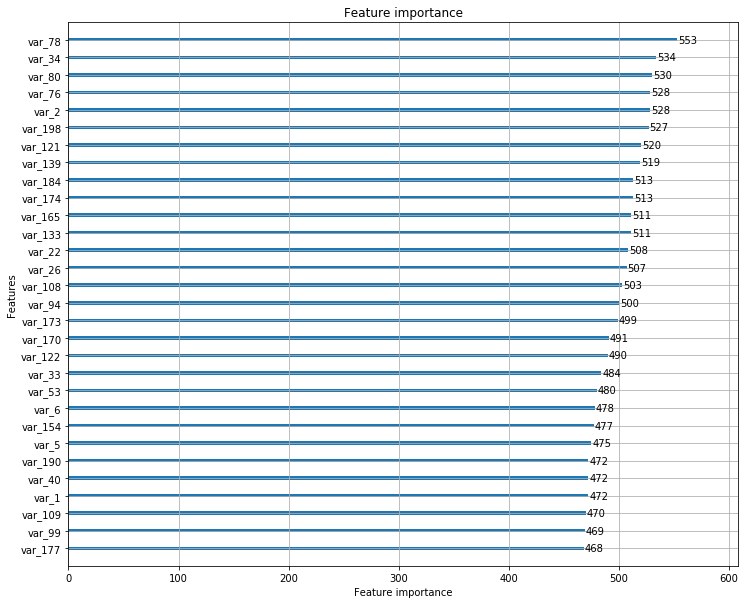

In [78]:
lgb.plot_importance(clf, max_num_features=30, importance_type='split',figsize=(12,10))

In [136]:
sub1=pd.read_csv("output/2019-3_22_lgb_augment_0.901_submission.csv")
sub2=pd.read_csv("output/submission-xgb_200_features.csv")
sub3=pd.read_csv("output/wavelet_without_aug_0.896.csv")
sub4=pd.read_csv("output/2019-03-16-NB_pipeline_0.889.csv")
sub5=pd.read_csv("output/submission-cat.csv")


In [140]:
sub['target']=sub1['target']*0.85+sub5['target']*0.06+sub4['target']*0.06\
              +sub3['target']*0.01+sub2['target']*0.01+0.01*sub['target']

In [142]:
sub.to_csv("output/blend-1.csv",index=False)